In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
from scipy.sparse.linalg import eigsh


from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import *
import networkx as nx

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

def compute_moments(psi, H):
    E = (psi.conj().T @ H.dot(psi)).real
    S = (psi.conj().T @ (H @ H).dot(psi)).real
    return E, S, S - E**2

In [2]:
def create_heisenberg_hamiltonian_(G, J):
    H = sum(J*( X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) ) for (i,j) in G.edges())
    return H

def calculate_spectra(L):
    G = nx.Graph()
    G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

    J = 1
    H = create_heisenberg_hamiltonian_(G, J)

    M = H.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')
    return eigenvalues, eigenvectors

x_val=list(range(4,22,2))

spectra = dict()
for L in x_val:
    spectra[L] = calculate_spectra(L) 

E0_val = dict()
E1_val = dict()
E0_vec = dict()
E1_vec = dict()

for L in x_val:
    E0_val[L] = spectra[L][0][0]
    E1_val[L] = spectra[L][0][1]

    E0_vec[L] = spectra[L][1][:,0]
    E1_vec[L] = spectra[L][1][:,1]

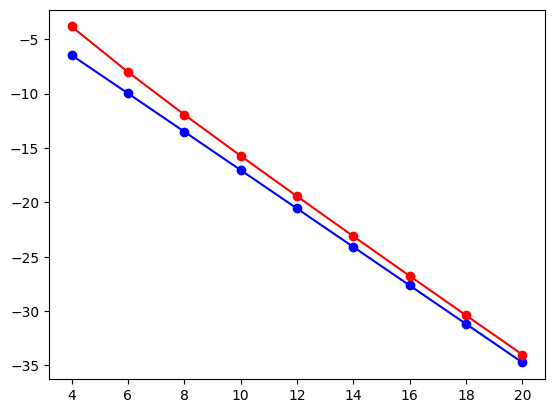

In [3]:
plt.plot(x_val, list(E0_val.values()), color='blue', marker='o', linestyle='solid')
plt.plot(x_val, list(E1_val.values()), color='red', marker='o', linestyle='solid')

In [76]:
# Load data
results_10 = load_data('data_PRL/benchmarks_2nd_L=10_04-17-13') 
results_12 = load_data('data_PRL/benchmarks_2nd_L=12_04-17-14')
results_14 = load_data('data_PRL/benchmarks_2nd_L=14_04-17-14')  
results_16 = load_data('data_PRL/benchmarks_2nd_L=16_04-17-15')  
results_18 = load_data('data_PRL/benchmarks_2nd_L=18_04-17-16')  
results_20 = load_data('data_PRL/benchmarks_2nd_L=20_04-17-19') 

results_dict = dict()
results_dict[10] = results_10
results_dict[12] = results_12
results_dict[14] = results_14
results_dict[16] = results_16
results_dict[18] = results_18
results_dict[20] = results_20


In [68]:
L=10
psi = E0_vec[L] # ground state
states = results_dict[L][1]["statevectors"] # 0 Singlet, 1 VQE
fidelities = []
for phi in states:
    fidelities.append(np.abs(np.dot(psi.conj().transpose(),phi))**2)

fidelities

[np.float64(0.8821139981274035),
 np.float64(0.9649437164203233),
 np.float64(0.9859960223027823),
 np.float64(0.9930120628470551),
 np.float64(0.9964600629648226),
 np.float64(0.9981150147793517)]

In [18]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(16)

In [61]:
def generate_plots(ax1, L):
    
    lables_energies=[r"$E_k\ |$Singlet$\rangle$",r"$E_k\ |$VQE$\rangle$"]
    lables_fidelities=[r"$F_k\ |$Singlet$\rangle$",r"$F_k\ |$VQE$\rangle$"]
    alphas = [1.0, 0.6]
    markers = ['d','o']
    indices = [0,1] 

    results = results_dict[L]

    ###############################################################################
    # SUBPLOT 1: Energy
    ###############################################################################

    # 1) Plot energies on the left y-axis
    for i,ind in enumerate(indices):
        line1, = ax1.plot(results[ind]['evolution_times'], results[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

    ax1.axhline(y=E0_val[L], color="red", linestyle=':', alpha=1.0)
    #ax1.axhline(y=E0_val[L]+0.1, color="orange", linestyle=':', alpha=0.8)
    ax1.axhline(y=E1_val[L], color="red", linestyle=':', alpha=0.6)

    ax1.text(
        0.2,           
        E0_val[L]+0.15,       
        r"$\lambda_0$",                          
        va="center",
        ha="left",
        color="red",
    )   

    ax1.text(
        0.2,           
        E1_val[L]+0.15,             
        r"$\lambda_1$",                           
        va="center",
        ha="left",
        color="red",
        alpha = 0.6
    )

    ax1.set_xlabel("Cumulative evolution duration")
    ax1.set_ylabel(r"Energy $E_k$")
    ax1.legend(loc="center right", fontsize=12)
    ax1.set_title(r"DB-QITE for L="+str(L))

    ###############################################################################
    # SUBPLOT 2: Fidelity
    ###############################################################################

    # 2) Create a twin axis for fluctuations
    axF = ax1.twinx()

    fidelities = dict()
    for ind in indices:
        # Calculate fidelities
        psi = E0_vec[L] # ground state
        states = results_dict[L][ind]["statevectors"]
        fidelities_ = []
        for phi in states:
            fidelities_.append(np.abs(np.dot(psi.conj().transpose(),phi))**2)
        fidelities[ind] = fidelities_

    # 1) Plot energies on the left y-axis
    for i,ind in enumerate(indices):
        line1, = axF.plot(results[ind]['evolution_times'], fidelities[ind], label=lables_fidelities[ind], color='green', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

    axF.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
    axF.axhline(y=0.975, color="orange", linestyle=':', alpha=0.8)
    axF.axhline(y=0.95, color="orange", linestyle=':', alpha=0.6)

    axF.set_ylabel(r"Fidelity to $|\lambda_0\rangle$")

    ###############################################################################

    # 3) Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = axF.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right", ncol=1, fontsize=12)


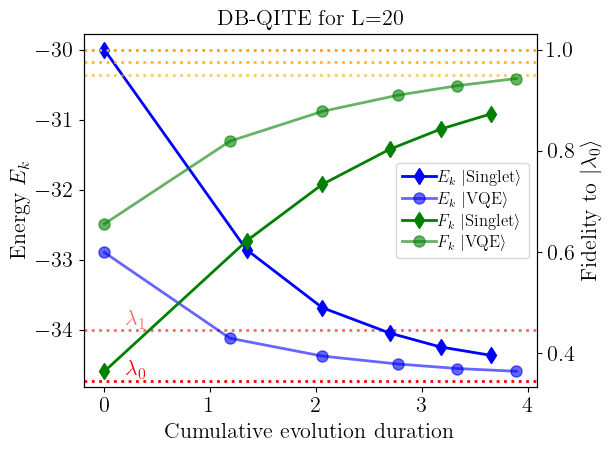

In [77]:
fig, ax1 = plt.subplots()
generate_plots(ax1,20)
plt.tight_layout()
plt.show()

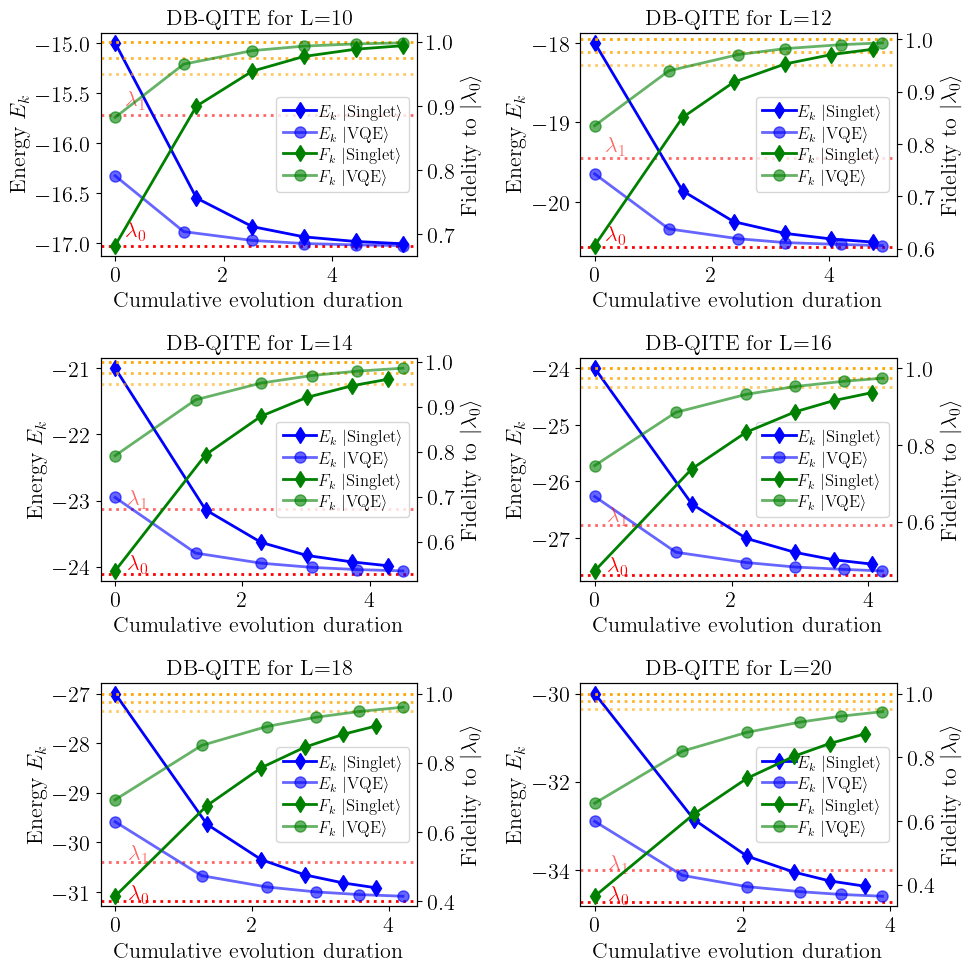

In [78]:
# Create a figure with 6 subplots (3 rows, 2 columns)
fig, ((ax_10, ax_12), (ax_14, ax_16), (ax_18, ax_20)) = plt.subplots(3, 2, 
                                             figsize=(10, 10), 
                                             gridspec_kw={"width_ratios": [1, 1], "height_ratios": [1,1,1]})

generate_plots(ax_10,10)
generate_plots(ax_12,12)
generate_plots(ax_14,14)
generate_plots(ax_16,16)
generate_plots(ax_18,18)
generate_plots(ax_20,20)

plt.tight_layout()
plt.savefig("plots_PRL/QITE.pdf")
plt.show()

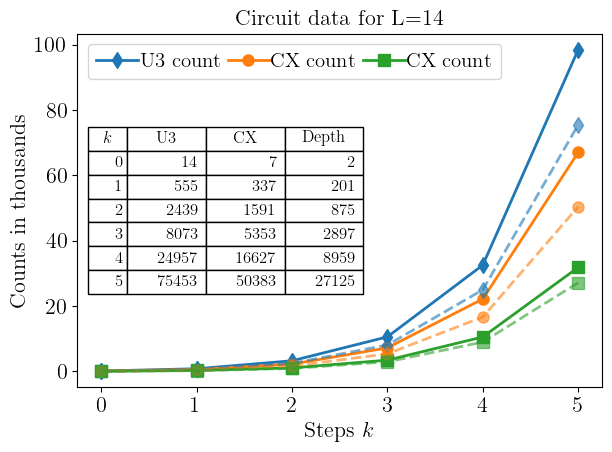

In [46]:
def generate_circuit_plots(axC, L):

    ###############################################################################
    # SUBPLOT 3: Circuit data 
    ###############################################################################
    results = results_dict[L]

    steps = [0,1,2,3,4,5]

    # Singlet
    u_count_S = np.array([results[0]["circuit_data"][0][k]['u3'] for k in steps])
    cx_count_S = np.array([results[0]["circuit_data"][0][k]['cx'] for k in steps])
    depth_S = np.array([results[0]["circuit_data"][2][k] for k in steps])

    # VQE
    u_count_V = np.array([results[1]["circuit_data"][0][k]['u3'] for k in steps])
    cx_count_V = np.array([results[1]["circuit_data"][0][k]['cx'] for k in steps])
    depth_V = np.array([results[1]["circuit_data"][2][k] for k in steps])

    scaling = 1000

    axC.plot(steps, u_count_V/scaling, marker='d', color='#1f77b4', alpha=1.0, label='U3 count')
    axC.plot(steps, cx_count_V/scaling, marker='o', color='#ff7f0e', alpha=1.0, label='CX count')
    axC.plot(steps, depth_V/scaling, marker='s', color='#2ca02c', alpha=1.0, label='CX count')

    axC.plot(steps, u_count_S/scaling, color='#1f77b4', marker='d', alpha=0.6, linestyle='dashed') 
    axC.plot(steps, cx_count_S/scaling, color='#ff7f0e', marker='o', alpha=0.6, linestyle='dashed') 
    axC.plot(steps, depth_S/scaling, color='#2ca02c', marker='s', alpha=0.6, linestyle='dashed') 

    axC.set_xlabel(r"Steps $k$")
    axC.set_ylabel("Counts in thousands")

    axC.legend(loc="upper left", ncols=3, fontsize=15)
    axC.set_title(r"Circuit data for L="+str(L))

    ###############################################################################
    # Inset table: circuit data GC
    ###############################################################################

    # Data for the table
    rows = [' 0 ', '1', '2', '3', '4', '5']
    columns = (r'$k$','U3', 'CX', 'Depth')
    cell_text = [[rows[i], u_count_S[i], cx_count_S[i], depth_S[i]] for i in range(6)]

    # Adjust column widths
    col_widths = [0.05, 0.1, 0.1, 0.1]  # First column is wider

    # Add a table at the bottom of the axes
    tableC = axC.table(cellText=cell_text,
                         colLabels=columns,
                        loc='center left',
                        colWidths=col_widths)
    tableC.auto_set_font_size(False)
    tableC.set_fontsize(12)
    tableC.scale(1.5, 1.5)  # Adjust the scaling as needed


fig, axC = plt.subplots()
generate_circuit_plots(axC,14)
plt.tight_layout()
plt.show()